# Using synthetic data, test `xclim` QDM functionality

Feb 2021

Following x`clim/xclim/testing/tests/test_sdba/diagnostics.py`

Note: the notebook installs `xclim` from a local clone that can be edited (hence a bunch of debugging output below). 

Also test local updates to the `xclim` package


In [1]:
# pip install -e /home/jovyan/xclim 

In [2]:
%matplotlib inline
import xarray as xr
import scipy as sp
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os 



In [3]:
import dask
import dask.array as da
import dask.distributed as dd
import rhg_compute_tools.kubernetes as rhgk

In [4]:
write_direc = '../figures/' #'/gcs/rhg-data/climate/downscaled/workdir'

In [5]:
import xclim
from xclim import sdba


## QDM 

I messed with my local copy of `xclim` so there are print messages. 

In [6]:
from scipy.stats import scoreatpercentile
from scipy.stats.kde import gaussian_kde

from xclim.testing.tests.test_sdba import utils as tu


First, reproduce the Cannon etal. 2015 data and outputs

In [7]:
# straight out of diagnostics.py
# the "m" in the variable names is for "multiplicative" to differentiate from other testing later in the notebook

n = 10000
refm, histm, simm = tu.cannon_2015_rvs(n, random=False)
    
QMm = sdba.adjustment.EmpiricalQuantileMapping(kind="*", group="time", nquantiles=100)
QMm.train(refm, histm)
simm_eqm = QMm.adjust(simm)
    

DQMm = sdba.adjustment.DetrendedQuantileMapping(kind="*", group="time", nquantiles=100)
DQMm.train(refm, histm)
simm_dqm = DQMm.adjust(simm, detrend=0)

QDMm = sdba.adjustment.QuantileDeltaMapping(kind="*", group="time", nquantiles=100)
QDMm.train(refm, histm)
simm_qdm = QDMm.adjust(simm)
histm_qdm = QDMm.adjust(histm)

extrapolate_qm @@@@@@@
extrapolate_qm @@@@@@@
extrapolate_qm @@@@@@@
extrapolate_qm @@@@@@@


One can access the adjustment factors "af" and "hist_q" inside of the QDM object's xr.Dataset, `ds`.

`af = ref_q / hist_q` for kind="*"

`af = ref_q - hist_q` for kind="+"



Text(0.5, 1.0, 'Reference and Historical GCM quantiles')

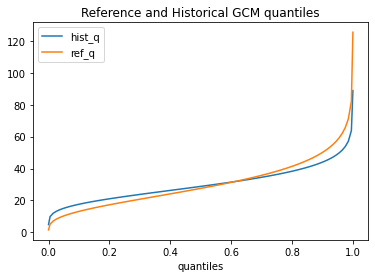

In [8]:
# Plot of the quantiled time series for GCM Hist (hist_q) and Obs Ref (ref_q) - these are basically cdfs

QDMm.ds.hist_q.plot()
(QDMm.ds.af * QDMm.ds.hist_q).plot()
plt.legend(('hist_q','ref_q'))
plt.title('Reference and Historical GCM quantiles')

### Cannon et al. 2015 Fig 2

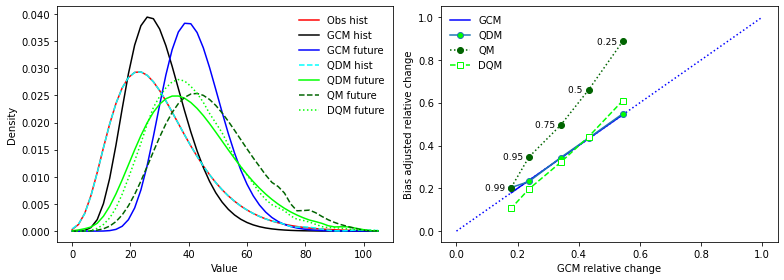

In [9]:
if 1: # copied from a func and didn't want to manually unindent
    # This comes from diagnostics.py and I think the right panel is specific to kind="*"
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
    x = np.linspace(0, 105, 50)
    ax1.plot(x, gaussian_kde(refm)(x), color="r", label="Obs hist")
    ax1.plot(x, gaussian_kde(histm)(x), color="k", label="GCM hist")
    ax1.plot(x, gaussian_kde(simm)(x), color="blue", label="GCM future")

    ax1.plot(x, gaussian_kde(histm_qdm)(x), color="cyan", linestyle='dashed',label="QDM hist")

    ax1.plot(x, gaussian_kde(simm_qdm)(x), color="lime", label="QDM future")
    ax1.plot(x, gaussian_kde(simm_eqm)(x), color="darkgreen", ls="--", label="QM future")
    ax1.plot(x, gaussian_kde(simm_dqm)(x), color="lime", ls=":", label="DQM future")
    ax1.legend(frameon=False)
    ax1.set_xlabel("Value")
    ax1.set_ylabel("Density")

    tau = np.array([0.25, 0.5, 0.75, 0.95, 0.99]) * 100
    bc_gcm = (
        scoreatpercentile(simm, tau) - scoreatpercentile(histm, tau)
    ) / scoreatpercentile(histm, tau)
    bc_qdm = (
        scoreatpercentile(simm_qdm, tau) - scoreatpercentile(refm, tau)
    ) / scoreatpercentile(refm, tau)
    bc_eqm = (
        scoreatpercentile(simm_eqm, tau) - scoreatpercentile(refm, tau)
    ) / scoreatpercentile(refm, tau)
    bc_dqm = (
        scoreatpercentile(simm_dqm, tau) - scoreatpercentile(refm, tau)
    ) / scoreatpercentile(refm, tau)

    ax2.plot([0, 1], [0, 1], ls=":", color="blue")
    ax2.plot(bc_gcm, bc_gcm, "-", color="blue", label="GCM")
    ax2.plot(bc_gcm, bc_qdm, marker="o", mfc="lime", label="QDM")
    ax2.plot(
        bc_gcm,
        bc_eqm,
        marker="o",
        mfc="darkgreen",
        ls=":",
        color="darkgreen",
        label="QM",
    )
    ax2.plot(
        bc_gcm,
        bc_dqm,
        marker="s",
        mec="lime",
        mfc="w",
        ls="--",
        color="lime",
        label="DQM",
    )

    for i, s in enumerate(tau / 100):
        ax2.text(bc_gcm[i], bc_eqm[i], f"{s}  ", ha="right", va="center", fontsize=9)
    ax2.set_xlabel("GCM relative change")
    ax2.set_ylabel("Bias adjusted relative change")
    ax2.legend(loc="upper left", frameon=False)
#     ax2.set_aspect("equal")
    plt.tight_layout()

    

## Synth data with `kind="+"` instead of "*"

Now we will test additive variables and other things

copied and adapted functions from ....`xclim/xclim/testing/tests/test_sdba/utils.py` 

#### Note
The following analyses and validation test on a single future time period for a single grid cell. 

For example, if a time series is defined to be 10,000 time steps, then one future cdf (per group if specified) over the whole time series is used to correct the future period. This notebook does not test rolling future cdfs as will be done in our actual implementation.

In [10]:
# these funcs modified from ~/xclim/xclim/testing/tests/test_sdba/utils.py
def my_series(values, name, start="2000-01-01"):
    import collections

    
    coords = collections.OrderedDict()
    for dim, n in zip(("time", "lon", "lat"), values.shape):
        if dim == "time":
            coords[dim] = pd.date_range(start, periods=n, freq=pd.DateOffset(days=1))
        else:
            coords[dim] = xr.IndexVariable(dim, np.arange(n))

    if name == "tas":
        attrs = {
            "standard_name": "air_temperature",
            "cell_methods": "time: mean within days",
            "units": "K",
            "kind": "+",
        }
    elif name == "pr":
        attrs = {
            "standard_name": "precipitation_flux",
            "cell_methods": "time: sum over day",
            "units": "kg m-2 s-1",
            "kind": "*",
        }

    return xr.DataArray(
        values,
        coords=coords,
        dims=list(coords.keys()),
        name=name,
        attrs=attrs,
    )

def my_dist():
    from scipy.stats import norm

    # ref ~ gamma(k=4, theta=7.5)  mu: 30, sigma: 15
    ref = norm(4, scale=7.5)

    # hist ~ gamma(k=8.15, theta=3.68) mu: 30, sigma: 10.5
    hist = norm(8.15, scale=3.68)

    # sim ~ gamma(k=16, theta=2.63) mu: 42, sigma: 10.5
    sim = norm(16, scale=2.63)

    return ref, hist, sim


def my_rvs(n, kind='+', random=True):
    # Frozen distributions
    if kind=='*':
        return tu.cannon_2015_rvs(n, random=random)
    else:
        fd = my_dist()

        if random:
            r = [d.rvs(n) for d in fd]
        else:
            raise NotImplementedError
    #         u = equally_spaced_nodes(n, None)
    #         r = [d.ppf(u) for d in fd]

        return map(lambda x: my_series(x, "tas"), r)


Now increase the number of quantiles in the bias correction *and try "+"*

In [11]:
random = True
nquantiles = 1000
n = 10000
kind = "+" #"*" #"+"

if kind=='*':
    kindstr='mult'
else:
    kindstr='add'

ref, hist, sim = my_rvs(n, kind, random=random)
QM = sdba.adjustment.EmpiricalQuantileMapping(kind=kind, group="time", nquantiles=nquantiles)
QM.train(ref, hist)
sim_eqm = QM.adjust(sim)
    

DQM = sdba.adjustment.DetrendedQuantileMapping(kind=kind, group="time", nquantiles=nquantiles)
DQM.train(ref, hist)
sim_dqm = DQM.adjust(sim, detrend=0)

QDM = sdba.adjustment.QuantileDeltaMapping(kind=kind, group="time", nquantiles=nquantiles)
QDM.train(ref, hist)
sim_qdm = QDM.adjust(sim)
hist_qdm = QDM.adjust(hist)

extrapolate_qm @@@@@@@
extrapolate_qm @@@@@@@
extrapolate_qm @@@@@@@
extrapolate_qm @@@@@@@


In [12]:
# add a ridiculously simple trend
totalchange = 20
trend = np.linspace(0,totalchange,len(sim.time))

simtrend = sim+trend
simtrend_qdm = QDM.adjust(simtrend)


extrapolate_qm @@@@@@@


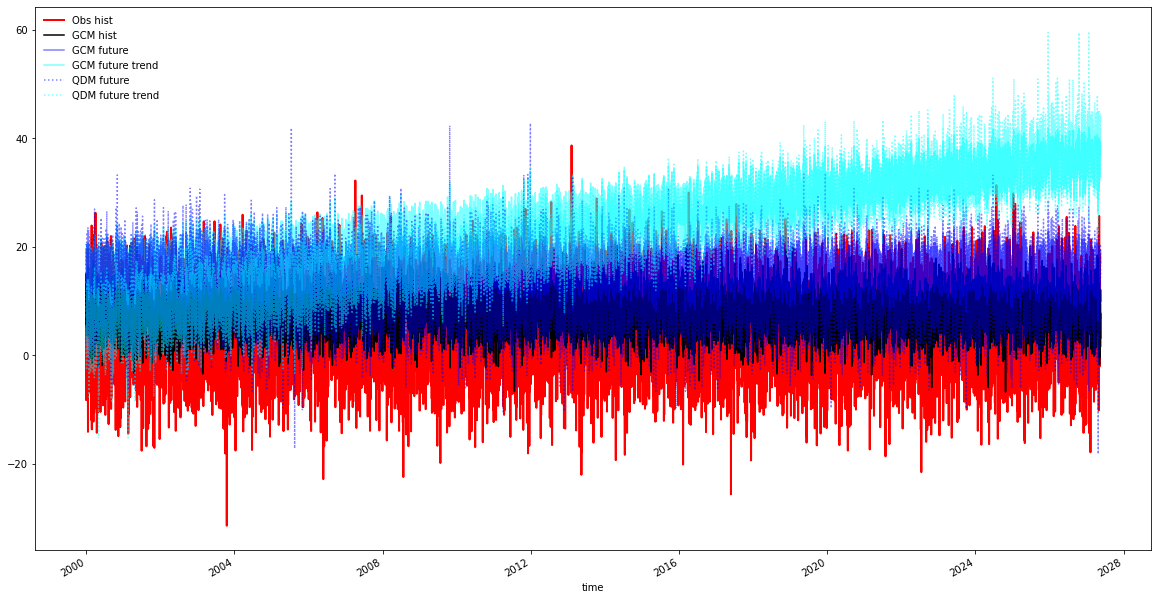

In [13]:
fig,ax = plt.subplots(1,1,figsize=(20,10))
ref.plot(ax=ax, linewidth=2, color="r", label="Obs hist")
hist.plot(ax=ax, color="k", label="GCM hist")
sim.plot(ax=ax, color="blue", label="GCM future", alpha=.5)
simtrend.plot(ax=ax, color="cyan", label="GCM future trend", alpha=.5)
sim_qdm.plot(ax=ax, linestyle=':', color="blue", label="QDM future", alpha=.5)
simtrend_qdm.plot(ax=ax, linestyle=':', color="cyan", label="QDM future trend", alpha=.5)
ax.legend(frameon=False)

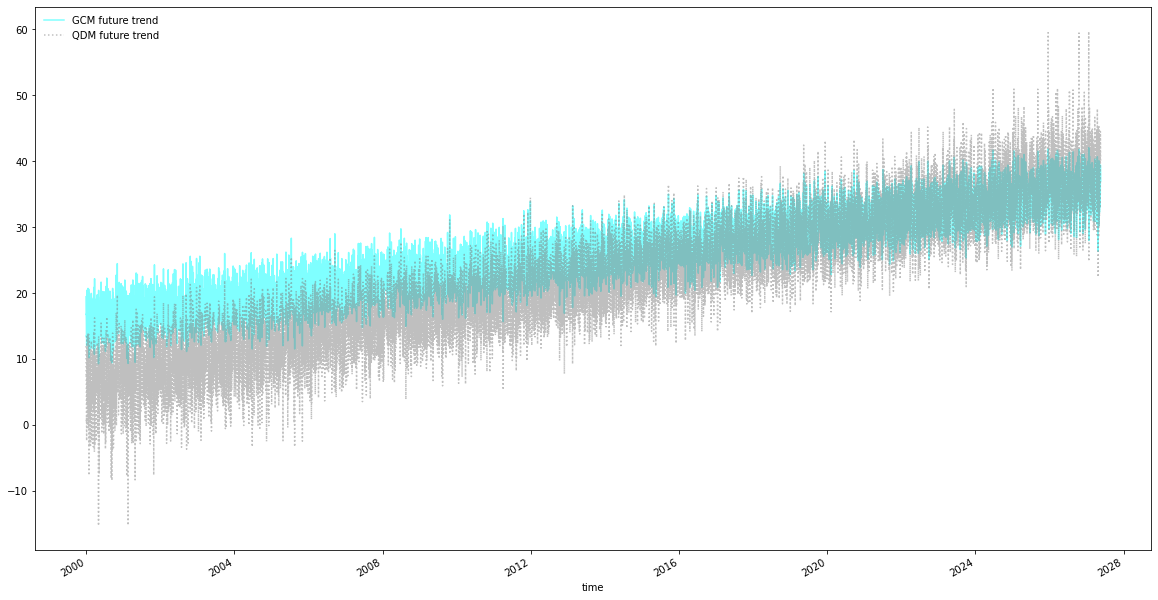

In [14]:
fig,ax = plt.subplots(1,1,figsize=(20,10))
simtrend.plot(ax=ax, color="cyan", label="GCM future trend", alpha=.5)
simtrend_qdm.plot(ax=ax, linestyle=':', color="gray", label="QDM future trend", alpha=.5)
ax.legend(frameon=False)

In [15]:
print('all days linear trend')
print('  sim    ', sp.stats.linregress(np.arange(len(sim.time)), sim.values).slope*n) # total change
print('  QDM sim', sp.stats.linregress(np.arange(len(sim_qdm.time)), sim_qdm.values).slope*n) # total change

print('\n  simtrend  ', sp.stats.linregress(np.arange(len(simtrend.time)), simtrend.values).slope*n)
print('  QDM simtrend', sp.stats.linregress(np.arange(len(simtrend_qdm.time)), simtrend_qdm.values).slope*n)


all days linear trend
  sim     -0.03139417312214608
  QDM sim -0.08639181118038536

  simtrend   19.97060602689786
  QDM simtrend 31.728237471811806


# is the trend preserved?
In `simtrend` we're expecting to see the added trend of `totalchange` above (=20 currently). The uncorrected trend is pretty close to 20, but the default behavior of QDM (`QDM simtrend`) clearly changes that here, where we're just checking the linear trend through all days. The trend is much steeper after QDM and this is true for kind="*" and kind="+"

This outcome may not be applicable to our actual method, which is grouped by day and will have a rolling future cdf. This is TBD.



### comparing quantiles - are the quantile trends preserved?

In [16]:
from plotting import quantile_compare_plot



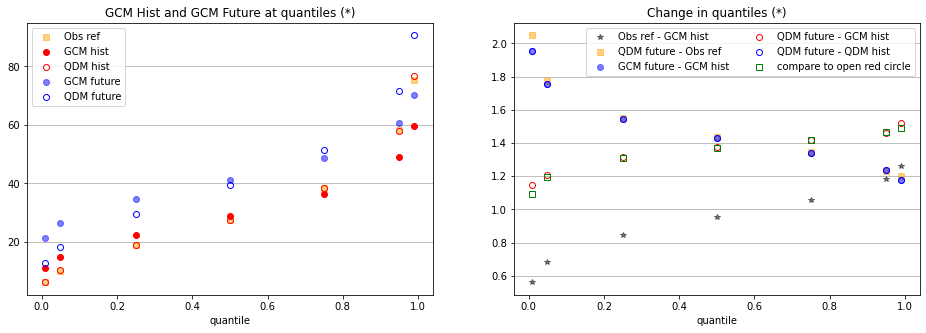

In [17]:
printtofile=False

_ = quantile_compare_plot((refm, histm, simm), (histm_qdm, simm_qdm), kind="*") # the Cannon data, with nquantiles=100

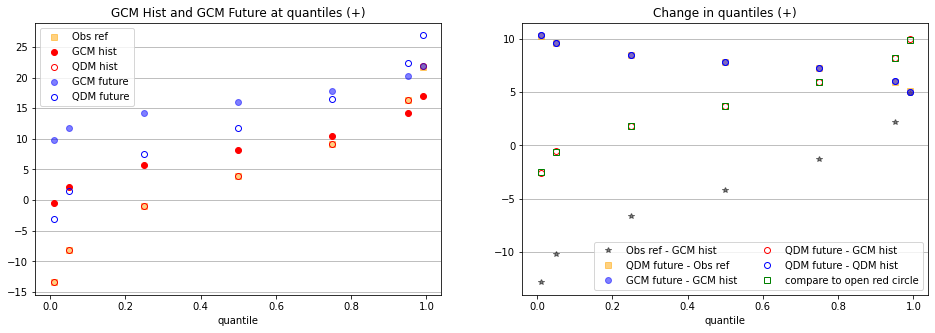

In [18]:
fig = quantile_compare_plot((ref,hist,sim),(hist_qdm, sim_qdm), kind="+") # my synth data, nquantiles=1000
if printtofile:
    fig.savefig('{}/QDM_synthtest_{}_quantile_changes_subplots.png'.format(write_direc,kindstr),dpi=200, bbox_inches='tight')

In [19]:
# this figure is mostly replaced by the above 

# printtofile=True


# if kind=='*':
#     kindstr='mult'
# else:
#     kindstr='add'
# quants = [.01, .05, .25, .5, .75, .95, .99]

# if kind=="+":
#     fig, axs = plt.subplots(2,2,figsize=(16,8),sharex=True)#, sharey=True)
#     ax=axs[0,0]
#     ref.quantile(quants).to_pandas().plot(ax=ax, linestyle='none', marker='s', alpha=.5, color='orange', label='Obs ref')
#     hist.quantile(quants).to_pandas().plot(ax=ax, linestyle='none', marker='o',color='red', label='GCM hist')
#     hist_qdm.quantile(quants).to_pandas().plot(ax=ax, linestyle='none', marker='o',mfc='none', color='red', label='QDM hist')
#     sim.quantile(quants).to_pandas().plot(ax=ax, linestyle='none', marker='o',alpha=.5, color='blue', label='GCM future')
#     sim_qdm.quantile(quants).to_pandas().plot(ax=ax, linestyle='none', marker='o',mfc='none', color='blue', label='QDM future')
#     ax.legend(loc='upper left')
#     ax.set_title('GCM Hist and GCM Future at quantiles ({})'.format(kind))
#     ax.grid(axis='y')
#     ax=axs[0,1]
#     ref.quantile(quants).to_pandas().plot(ax=ax, linestyle='none', marker='s', alpha=.5, color='orange', label='Obs ref')
#     hist.quantile(quants).to_pandas().plot(ax=ax, linestyle='none', marker='o',color='red', label='GCM hist')
#     hist_qdm.quantile(quants).to_pandas().plot(ax=ax, linestyle='none', marker='o',mfc='none', color='red', label='QDM hist')
#     simtrend.quantile(quants).to_pandas().plot(ax=ax, linestyle='none', marker='o',alpha=.5, color='blue', label='GCM future trend')
#     simtrend_qdm.quantile(quants).to_pandas().plot(ax=ax, linestyle='none', marker='o',mfc='none', color='blue', label='QDM future trend')
#     ax.legend()
#     ax.set_title('GCM Hist and GCM Future with Trend at quantiles ({})'.format(kind))
#     ax.grid(axis='y')

#     ax=axs[1,0]
#     (ref.quantile(quants)-hist.quantile(quants)).to_pandas().plot(ax=ax, linestyle='none', marker='*', alpha=.5, color='black', label='Obs ref - GCM hist')
#     (sim_qdm.quantile(quants)-ref.quantile(quants)).to_pandas().plot(ax=ax, linestyle='none', marker='s', alpha=.5, color='orange', label='QDM future - Obs ref')
#     (sim.quantile(quants)-hist.quantile(quants)).to_pandas().plot(ax=ax, linestyle='none', marker='o', alpha=.5, color='blue', label='GCM future - GCM hist')
#     (sim_qdm.quantile(quants)-hist.quantile(quants)).to_pandas().plot(ax=ax, linestyle='none', marker='o', mfc='none', color='red', label='QDM future - GCM hist')
#     (sim_qdm.quantile(quants)-hist_qdm.quantile(quants)).to_pandas().plot(ax=ax, linestyle='none', marker='o', mfc='none', color='blue', label='QDM future - QDM hist')
#     ((ref.quantile(quants)-hist.quantile(quants))+(sim.quantile(quants)-hist.quantile(quants))).to_pandas().plot(ax=ax, linestyle='none', marker='s', mfc='none', color='green', label='compare to open red circle')
#     ax.legend(ncol=2, frameon=False)
#     ax.set_title('Change in quantiles ({})'.format(kind))
#     ax.grid(axis='y')
#     ax=axs[1,1]
#     (ref.quantile(quants)-hist.quantile(quants)).to_pandas().plot(ax=ax, linestyle='none', marker='*', alpha=.5, color='black', label='Obs ref - GCM hist')
#     (simtrend_qdm.quantile(quants)-ref.quantile(quants)).to_pandas().plot(ax=ax, linestyle='none', marker='s', alpha=.5, color='orange', label='QDM future trend - Obs ref')
#     (simtrend.quantile(quants)-hist.quantile(quants)).to_pandas().plot(ax=ax, linestyle='none', marker='o', alpha=.5, color='blue', label='GCM future trend - GCM hist')
#     (simtrend_qdm.quantile(quants)-hist.quantile(quants)).to_pandas().plot(ax=ax, linestyle='none', marker='o', mfc='none', color='red', label='QDM future trend - GCM hist')
#     (simtrend_qdm.quantile(quants)-hist_qdm.quantile(quants)).to_pandas().plot(ax=ax, linestyle='none', marker='o', mfc='none', color='blue', label='QDM future trend - QDM hist')
#     ((ref.quantile(quants)-hist.quantile(quants))+(simtrend.quantile(quants)-hist.quantile(quants))).to_pandas().plot(ax=ax, linestyle='none', marker='s', mfc='none', color='green', label='compare to open red circle')
#     ax.legend(ncol=2,frameon=False)
#     ax.set_title('Change in quantiles ({})'.format(kind))
#     ax.grid(axis='y')

# else:
        
#     fig, axs = plt.subplots(2,2,figsize=(16,8),sharex=True)#, sharey=True)
#     ax=axs[0,0]
#     ref.quantile(quants).to_pandas().plot(ax=ax, linestyle='none', marker='s', alpha=.5, color='orange', label='Obs ref')
#     hist.quantile(quants).to_pandas().plot(ax=ax, linestyle='none', marker='o',color='red', label='GCM hist')
#     hist_qdm.quantile(quants).to_pandas().plot(ax=ax, linestyle='none', marker='o',mfc='none', color='red', label='QDM hist')
#     sim.quantile(quants).to_pandas().plot(ax=ax, linestyle='none', marker='o',alpha=.5, color='blue', label='GCM future')
#     sim_qdm.quantile(quants).to_pandas().plot(ax=ax, linestyle='none', marker='o',mfc='none', color='blue', label='QDM future')
#     ax.legend(loc='upper left')
#     ax.set_title('GCM Hist and GCM Future at quantiles ({})'.format(kind))
#     ax.grid(axis='y')
#     ax=axs[0,1]
#     ref.quantile(quants).to_pandas().plot(ax=ax, linestyle='none', marker='s', alpha=.5, color='orange', label='Obs ref')
#     hist.quantile(quants).to_pandas().plot(ax=ax, linestyle='none', marker='o',color='red', label='GCM hist')
#     hist_qdm.quantile(quants).to_pandas().plot(ax=ax, linestyle='none', marker='o',mfc='none', color='red', label='QDM hist')
#     simtrend.quantile(quants).to_pandas().plot(ax=ax, linestyle='none', marker='o',alpha=.5, color='blue', label='GCM future trend')
#     simtrend_qdm.quantile(quants).to_pandas().plot(ax=ax, linestyle='none', marker='o',mfc='none', color='blue', label='QDM future trend')
#     ax.legend()
#     ax.set_title('GCM Hist and GCM Future with Trend at quantiles ({})'.format(kind))
#     ax.grid(axis='y')

#     ax=axs[1,0]
#     (ref.quantile(quants)/hist.quantile(quants)).to_pandas().plot(ax=ax, linestyle='none', marker='*', alpha=.5, color='black', label='Obs ref - GCM hist')
#     (sim_qdm.quantile(quants)/ref.quantile(quants)).to_pandas().plot(ax=ax, linestyle='none', marker='s', alpha=.5, color='orange', label='QDM future - Obs ref')
#     (sim.quantile(quants)/hist.quantile(quants)).to_pandas().plot(ax=ax, linestyle='none', marker='o', alpha=.5, color='blue', label='GCM future - GCM hist')
#     (sim_qdm.quantile(quants)/hist.quantile(quants)).to_pandas().plot(ax=ax, linestyle='none', marker='o', mfc='none', color='red', label='QDM future - GCM hist')
#     (sim_qdm.quantile(quants)/hist_qdm.quantile(quants)).to_pandas().plot(ax=ax, linestyle='none', marker='o', mfc='none', color='blue', label='QDM future - QDM hist')
#     ((ref.quantile(quants)/hist.quantile(quants))*(sim.quantile(quants)/hist.quantile(quants))).to_pandas().plot(ax=ax, linestyle='none', marker='s', mfc='none', color='green', label='compare to open red circle')
#     ax.legend(ncol=2, frameon=False)
#     ax.set_title('Change in quantiles ({})'.format(kind))
#     ax.grid(axis='y')
#     ax=axs[1,1]
#     (ref.quantile(quants)/hist.quantile(quants)).to_pandas().plot(ax=ax, linestyle='none', marker='*', alpha=.5, color='black', label='Obs ref - GCM hist')
#     (simtrend_qdm.quantile(quants)/ref.quantile(quants)).to_pandas().plot(ax=ax, linestyle='none', marker='s', alpha=.5, color='orange', label='QDM future trend - Obs ref')
#     (simtrend.quantile(quants)/hist.quantile(quants)).to_pandas().plot(ax=ax, linestyle='none', marker='o', alpha=.5, color='blue', label='GCM future trend - GCM hist')
#     (simtrend_qdm.quantile(quants)/hist.quantile(quants)).to_pandas().plot(ax=ax, linestyle='none', marker='o', mfc='none', color='red', label='QDM future trend - GCM hist')
#     (simtrend_qdm.quantile(quants)/hist_qdm.quantile(quants)).to_pandas().plot(ax=ax, linestyle='none', marker='o', mfc='none', color='blue', label='QDM future trend - QDM hist')
#     ((ref.quantile(quants)/hist.quantile(quants))*(simtrend.quantile(quants)/hist.quantile(quants))).to_pandas().plot(ax=ax, linestyle='none', marker='s', mfc='none', color='green', label='compare to open red circle')
#     ax.legend(ncol=2,frameon=False)
#     ax.set_title('Change in quantiles ({})'.format(kind))
#     ax.grid(axis='y')
    
# if printtofile:
#     fig.savefig('{}/QDM_synthtest_{}_quantile_changes_subplots.png'.format(write_direc,kindstr),dpi=200, bbox_inches='tight')


The above figure analyzes the quantiles of the raw and QDM corrected synthetic time series from Cannon et al. 2015 if when `kind="*"` and adjusted to a normal dist when `kind="+"` <strike>(left), and with a fake trend applied to the same synthetic future data (right). The full time series (length defined by setting `n` in days) are quantiled, ungrouped, in this analysis, because that is what is passed to QDM as well. Currently, the right column with a trend in the future data doesn't really add much yet, so focus on the left column.</strike> **TODO: change to box and whiskers plots**

### Left: quantiles for `Obs ref` and corrected and uncorrected `GCM hist`, `GCM future` with and without trend.

Expected behavior of applying QDM:
- GCM hist should look almost exactly like Obs ref, by design
- applying QDM should widen the quantile spread of GCM hist and GCM future because observations have a wider quantile spread than GCM hist

Realized behavior (additive):
- <span style="color:green">YES:</span> corrected GCM hist (open red) has the same quantile values as Obs ref (orange square)
- <span style="color:green">YES:</span> Comparing open circles (QDM) to closed circles (uncorrected) of the same colors, we see that quantile spread is widened in the corrected data (QDM hist and QDM future)

Realized behavior (multiplicative):
- Same as additive! Woot!


### Right: the difference in the un/corrected GCM future quantiles vs the un/corrected GCM hist and Obs ref quantiles

Expected behavior:
- the quantile differences between GCM future and GCM hist (blue circle) should be preserved after applying QDM --> thus (QDM future - QDM hist) should be the same as (GCM future - GCM hist) (compare open and closed blue circle). 
- the quantile differences between QDM future and uncorrected GCM hist (open red circle) should look like the combination of (GCM hist-Obs ref; black star) and (GCM future-GCM hist; closed blue circle): these differences are summed and shown as open green squared
- the quantile differences between QDM future and QDM hist (blue open circle) should be equal to the differences between QDM future and Obs ref (orange square)
- the quantile differences between Obs ref and QDM hist should be zero (not shown)

Realized behavior (additive):
- <span style="color:green">YES:</span> woot the quantile differences b/w uncorrected and QDM'd future and hist are preserved! open and closed blue circles are the same. As a bonus, so is orange square (QDM future - Obs ref) which is also expected
- <span style="color:green">YES:</span> QDM future - GCM hist (open red) IS the combination of (GCM hist - Obs ref; the original bias correction; black star) and the future quantile change (GCM future-GCM hist; closed blue). The open green squares are on top of the open red circles.
- <span style="color:green">YES:</span> as stated in bullet one, orange square (QDM Future - Obs ref) is the same as change in GCM quantiles (QDM future - QDM hist or GCM future - GCM hist)
- not shown

Realized behavior (multiplicative):
- same as additive! yesss


## The method works properly!
The difference from our schematic is that in our schematic, we compute the deltas (GCM Future - GCM Hist), and then *bias correct GCM Hist to match Obs Ref* to get a historical observationally corrected time series. Then we would add the deltas to the result of that to get the QDM Future time series. 

HERE in xclim QDM, we don't bias correct GCM Hist and add to it. We just compute the mapping from GCM Hist to Obs Ref, and add it straight to GCM Future. I think it's what Bob was saying all along.

Note that the number of quantiles *does* have an effect on the ability of QDM to preserve trends in the tails, with more quantiles doing a better job of it.

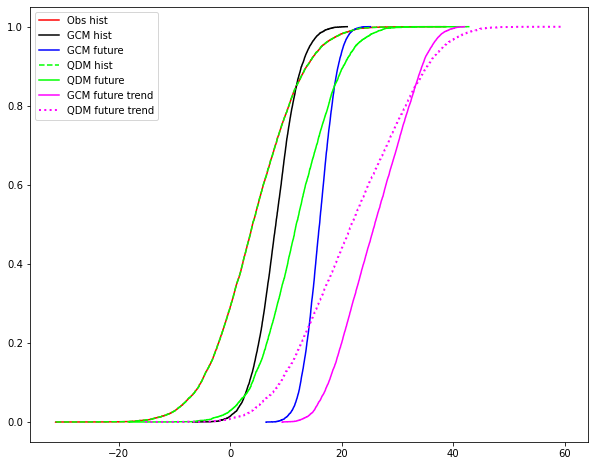

In [20]:
import statsmodels.api as sm

    
ref_ecdf = sm.distributions.ECDF(ref)
hist_ecdf = sm.distributions.ECDF(hist)
sim_ecdf = sm.distributions.ECDF(sim)
histqdm_ecdf = sm.distributions.ECDF(hist_qdm)
simqdm_ecdf = sm.distributions.ECDF(sim_qdm)
simtrend_ecdf = sm.distributions.ECDF(simtrend)
simtrendqdm_ecdf = sm.distributions.ECDF(simtrend_qdm)

fig,ax = plt.subplots(1,1,figsize=(10,8))

ax.step(ref_ecdf.x,ref_ecdf.y, color="r", label="Obs hist")
ax.step(hist_ecdf.x,hist_ecdf.y, color="k", label="GCM hist")
ax.step(sim_ecdf.x,sim_ecdf.y, color="blue", label="GCM future")
ax.step(histqdm_ecdf.x,histqdm_ecdf.y, color="lime", linestyle='dashed', label="QDM hist")
ax.step(simqdm_ecdf.x,simqdm_ecdf.y, color="lime", label="QDM future")
ax.step(simtrend_ecdf.x,simtrend_ecdf.y, color="magenta", label="GCM future trend")
ax.step(simtrendqdm_ecdf.x,simtrendqdm_ecdf.y, color="magenta", linewidth=2, linestyle=":", label="QDM future trend")
ax.legend()

The following figure right panel isn't yet updated to work with "+" data. TODO update it

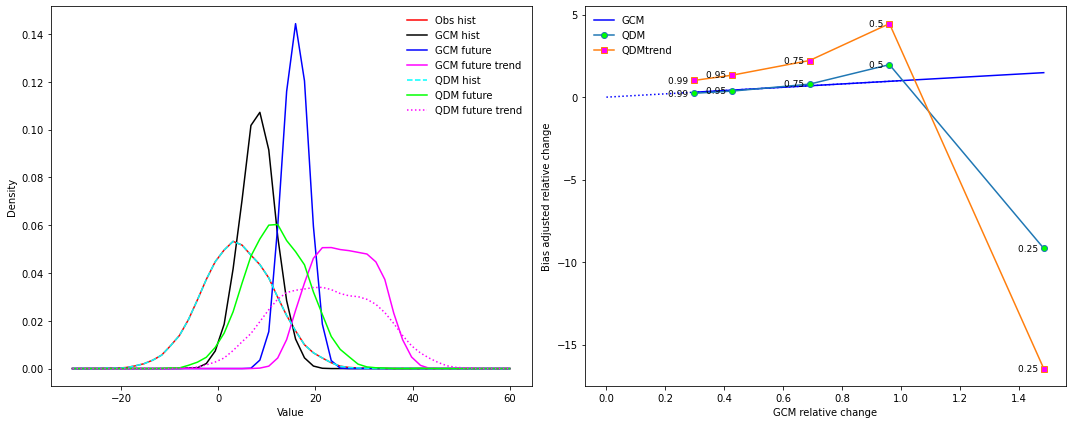

In [21]:
if 1:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    x = np.linspace(-30, 60, 50)
    ax1.plot(x, gaussian_kde(ref)(x), color="r", label="Obs hist")
    ax1.plot(x, gaussian_kde(hist)(x), color="k", label="GCM hist")
    ax1.plot(x, gaussian_kde(sim)(x), color="blue", label="GCM future")
    ax1.plot(x, gaussian_kde(simtrend)(x), color="magenta", label="GCM future trend")

    ax1.plot(x, gaussian_kde(hist_qdm)(x), color="cyan", linestyle='dashed',label="QDM hist")

    ax1.plot(x, gaussian_kde(sim_qdm)(x), color="lime", label="QDM future")
    ax1.plot(x, gaussian_kde(simtrend_qdm)(x), color="magenta",linestyle=":", label="QDM future trend")
#     ax1.plot(x, gaussian_kde(sim_eqm)(x), color="darkgreen", ls="--", label="QM future")
#     ax1.plot(x, gaussian_kde(sim_dqm)(x), color="lime", ls=":", label="DQM future")
    ax1.legend(frameon=False)
    ax1.set_xlabel("Value")
    ax1.set_ylabel("Density")

    tau = np.array([0.25, 0.5, 0.75, 0.95, 0.99]) * 100
    bc_gcm = (
        scoreatpercentile(sim, tau) - scoreatpercentile(hist, tau)
    ) / scoreatpercentile(hist, tau)
    bc_qdm = (
        scoreatpercentile(sim_qdm, tau) - scoreatpercentile(ref, tau)
    ) / scoreatpercentile(ref, tau)
    bctrend_qdm = (
        scoreatpercentile(simtrend_qdm, tau) - scoreatpercentile(ref, tau)
    ) / scoreatpercentile(ref, tau)
#     bc_eqm = (
#         scoreatpercentile(sim_eqm, tau) - scoreatpercentile(ref, tau)
#     ) / scoreatpercentile(ref, tau)
#     bc_dqm = (
#         scoreatpercentile(sim_dqm, tau) - scoreatpercentile(ref, tau)
#     ) / scoreatpercentile(ref, tau)

    ax2.plot([0, 1], [0, 1], ls=":", color="blue")
    ax2.plot(bc_gcm, bc_gcm, "-", color="blue", label="GCM")
    ax2.plot(bc_gcm, bc_qdm, marker="o", mfc="lime", label="QDM")
    ax2.plot(bc_gcm, bctrend_qdm, marker="s", mfc="magenta", label="QDMtrend")
#     ax2.plot(
#         bc_gcm,
#         bc_eqm,
#         marker="o",
#         mfc="darkgreen",
#         ls=":",
#         color="darkgreen",
#         label="QM",
#     )
#     ax2.plot(
#         bc_gcm,
#         bc_dqm,
#         marker="s",
#         mec="lime",
#         mfc="w",
#         ls="--",
#         color="lime",
#         label="DQM",
#     )

    for i, s in enumerate(tau / 100):
#         ax2.text(bc_gcm[i], bc_eqm[i], f"{s}  ", ha="right", va="center", fontsize=9)
        ax2.text(bc_gcm[i], bc_qdm[i], f"{s}  ", ha="right", va="center", fontsize=9)
        ax2.text(bc_gcm[i], bctrend_qdm[i], f"{s}  ", ha="right", va="center", fontsize=9)
    ax2.set_xlabel("GCM relative change")
    ax2.set_ylabel("Bias adjusted relative change")
    ax2.legend(loc="upper left", frameon=False)
#     ax2.set_aspect("equal")
    plt.tight_layout()

    

# Test day grouping, no window
The synth data isn't great for day grouping b/c there's no seasonal cycle, so I added a fake seasonal cycle below.

Note that the synthetic data is *randomized* and so it's a slightly different dataset each time you run the next cell, so make sure to remake everything.

In [23]:
random = True
n = 50000 # longer time series b/c day grouping
nquantiles = int(np.floor(n/366)) # want these to be ~ empirical, so n/366 days in a year
print('quantiles are approximately empirical. Daily time series length of {} with day grouping yields:'.format(n))
print('nquantiles', nquantiles)

kind = "+" #"*" #"+"

if kind=='*':
    kindstr='mult'
else:
    kindstr='add'

refdg, histdg, simdg = my_rvs(n, kind, random=random) # "dg" for day group


quantiles are approximately empirical. Daily time series length of 50000 with day grouping yields:
nquantiles 136


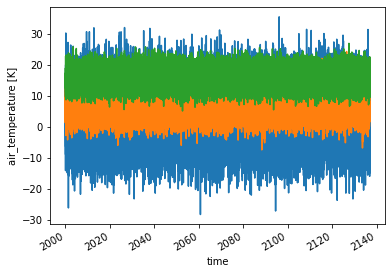

In [24]:
refdg.plot()
histdg.plot()
simdg.plot()
# simdg_qdm.plot(linestyle=':')

Add a seasonal cycle to the synth data

From: http://xarray.pydata.org/en/stable/examples/weather-data.html#Toy-weather-data

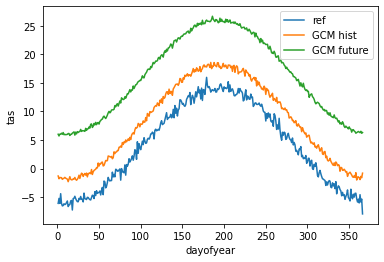

In [25]:
annual_cycle = np.sin(2 * np.pi * (refdg.time.dt.dayofyear.values / 365.25 - 0.28)) 
refdg = (refdg+ 10*annual_cycle )

histdg = (histdg+ 10*annual_cycle )

simdg = (simdg+ 10*annual_cycle)

refdg.groupby('time.dayofyear').mean().plot(label='ref')
histdg.groupby('time.dayofyear').mean().plot(label='GCM hist')
simdg.groupby('time.dayofyear').mean().plot(label='GCM future')
plt.legend()
# base + 3 * np.random.randn(annual_cycle.size, 3)

### do the bias correction

In [26]:
QMdg = sdba.adjustment.EmpiricalQuantileMapping(kind=kind, group="time.dayofyear", nquantiles=nquantiles)
QMdg.train(refdg, histdg)
simdg_eqm = QMdg.adjust(simdg)
    
DQMdg = sdba.adjustment.DetrendedQuantileMapping(kind=kind, group="time.dayofyear", nquantiles=nquantiles)
DQMdg.train(refdg, histdg)
simdg_dqm = DQMdg.adjust(simdg, detrend=0)

QDMdg = sdba.adjustment.QuantileDeltaMapping(kind=kind, group="time.dayofyear", nquantiles=nquantiles)
QDMdg.train(refdg, histdg)
simdg_qdm = QDMdg.adjust(simdg)
histdg_qdm = QDMdg.adjust(histdg)

extrapolate_qm @@@@@@@
extrapolate_qm @@@@@@@
extrapolate_qm @@@@@@@
extrapolate_qm @@@@@@@


Text(0.5, 1.0, 'Daily mean')

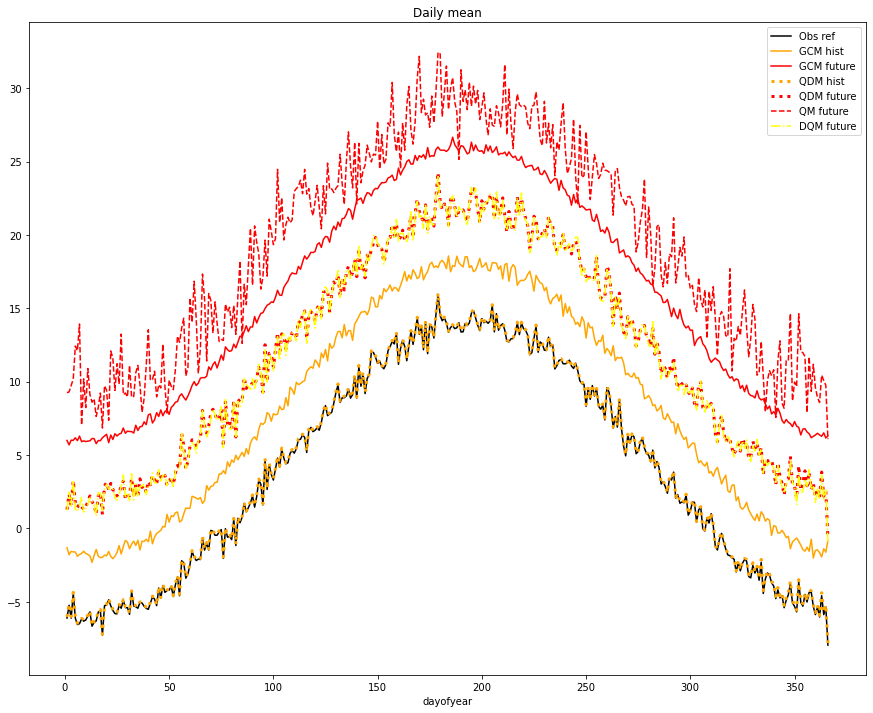

In [27]:
fig, ax = plt.subplots(1,1,figsize=(15,12))
refdg.groupby('time.dayofyear').mean().plot(color='k', label='Obs ref')
histdg.groupby('time.dayofyear').mean().plot(color='orange', label='GCM hist')
simdg.groupby('time.dayofyear').mean().plot(color='r', label='GCM future')
histdg_qdm.groupby('time.dayofyear').mean().plot(color='orange', linestyle=':', linewidth=3, label='QDM hist')
simdg_qdm.groupby('time.dayofyear').mean().plot(color='r', linestyle=':', linewidth=3, label='QDM future')
simdg_eqm.groupby('time.dayofyear').mean().plot(color='r', linestyle='--', label='QM future')
simdg_dqm.groupby('time.dayofyear').mean().plot(color='yellow', linestyle='-.', label='DQM future')
ax.legend()
ax.set_title('Daily mean')

Looks like DQM gives the same result as QDM in this example and metric. Is that expected?

#### show quantiles of GCM Future and QDM Future

Text(0.5, 1.0, 'Daily 1-99 ranges')

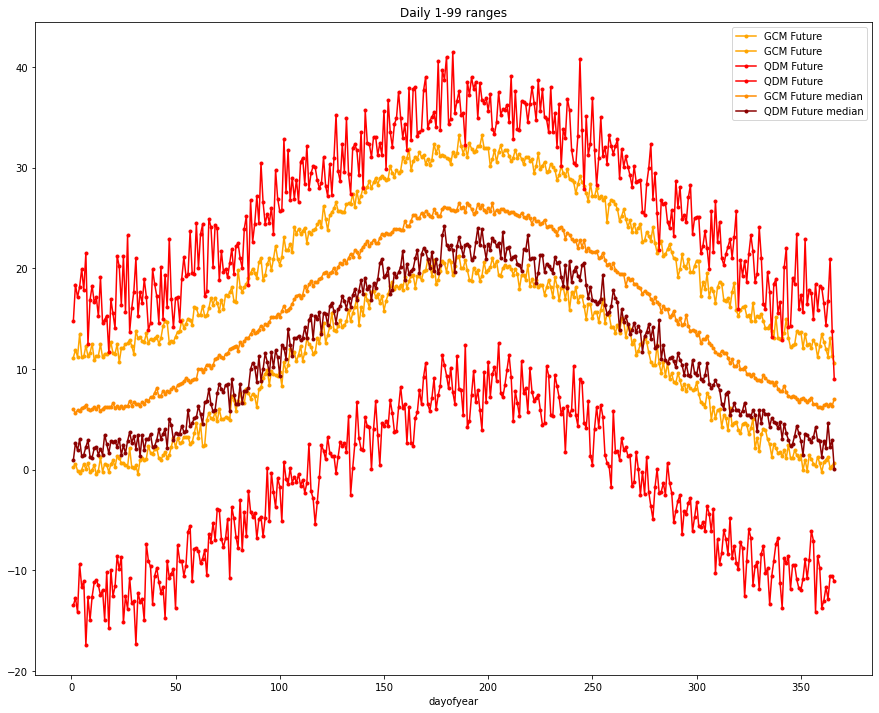

In [28]:

quants = [.01, .99]

fig, ax =plt.subplots(1,1,figsize=(15,12))

_ = simdg.groupby('time.dayofyear').quantile(quants).plot.line(x='dayofyear', color='orange', marker='.', label="GCM Future")
_ = simdg_qdm.groupby('time.dayofyear').quantile(quants).plot.line(x='dayofyear', color='red', marker='.', label="QDM Future")
_ = simdg.groupby('time.dayofyear').quantile([.5,]).plot.line(x='dayofyear', color='darkorange', marker='.', label="GCM Future median")
_ = simdg_qdm.groupby('time.dayofyear').quantile([.5,]).plot.line(x='dayofyear', color='darkred', marker='.', label="QDM Future median")
ax.legend()

ax.set_title('Daily 1-99 ranges')

In the next figure, we're plotting the difference in quantile in the raw GCM (GCM Future - GCM Hist) and in the corrected GCM (QDM Future - QDM Hist) for each day of the year

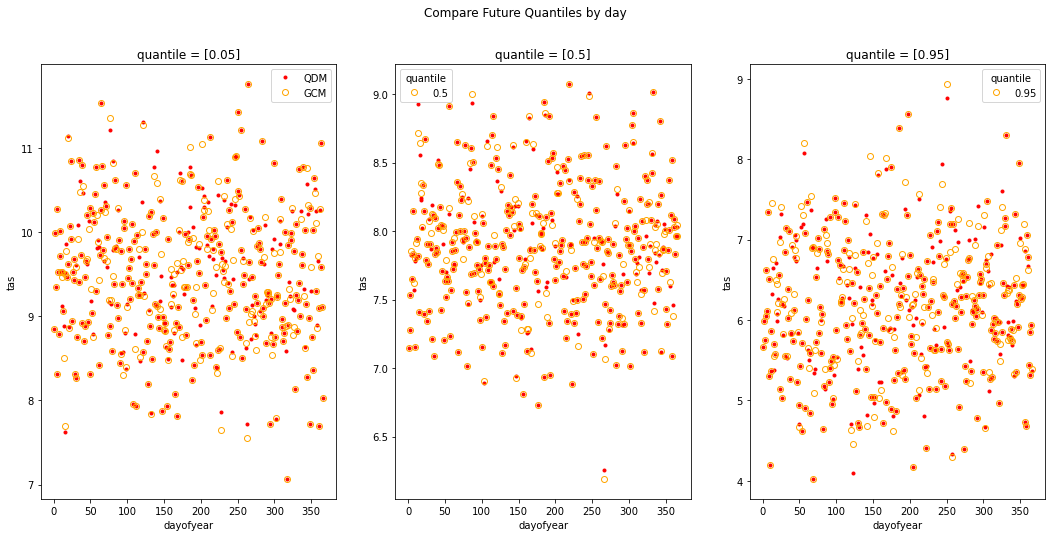

In [29]:
# TODO: replace with a call to `_ = compare_gcm_qdm_quantiles((refdg, histdg, simdg), (histdg_qdm, simdg_qdm), grouper='time.dayofyear')` and import this func from plotting.py

fig,axs=plt.subplots(1,3,figsize=(18,8))
quants=[.05,]
ax=axs[0]
_ = (simdg_qdm.groupby('time.dayofyear').quantile(quants)
     -histdg_qdm.groupby('time.dayofyear').quantile(quants)).plot.line(ax=ax, x='dayofyear', color='red', linestyle='none', marker='.', label="QDM")
_ = (simdg.groupby('time.dayofyear').quantile(quants)
     -histdg.groupby('time.dayofyear').quantile(quants)).plot.line(ax=ax, x='dayofyear', color='orange', linestyle='none', marker='o', mfc='none', label="GCM")
ax.legend()

quants=[.5,]
ax=axs[1]
_ = (simdg_qdm.groupby('time.dayofyear').quantile(quants)
     -histdg_qdm.groupby('time.dayofyear').quantile(quants)).plot.line(ax=ax, x='dayofyear', color='red', linestyle='none', marker='.', label="QDM")
_ = (simdg.groupby('time.dayofyear').quantile(quants)
     -histdg.groupby('time.dayofyear').quantile(quants)).plot.line(ax=ax, x='dayofyear', color='orange', linestyle='none', marker='o', mfc='none', label="GCM")


quants=[.95]
ax=axs[2]
_ = (simdg_qdm.groupby('time.dayofyear').quantile(quants)
     -histdg_qdm.groupby('time.dayofyear').quantile(quants)).plot.line(ax=ax, x='dayofyear', color='red', linestyle='none', marker='.', label="QDM")
_ = (simdg.groupby('time.dayofyear').quantile(quants)
     -histdg.groupby('time.dayofyear').quantile(quants)).plot.line(ax=ax, x='dayofyear', color='orange', linestyle='none', marker='o', mfc='none', label="GCM")

_ = fig.suptitle('Compare Future Quantiles by day ')

Quantiles in raw and uncorrected DO NOT match for all days of the year. Why is this? Is grouping incorrect? I can't see a pattern to the differences.

The next figure is a different way to look at this comparison - scatter plot of raw quantile differences (GCM Future - GCM Hist) vs corrected quantile differences (QDM Future - QDM Hist). You can see most of them line up along the 1:1 line, but not all. The colors indicate the `dayofyear`. Again I don't see a pattern.

Is it possible that leap days cause a problem?

Text(0.5, 1.0, '0.95')

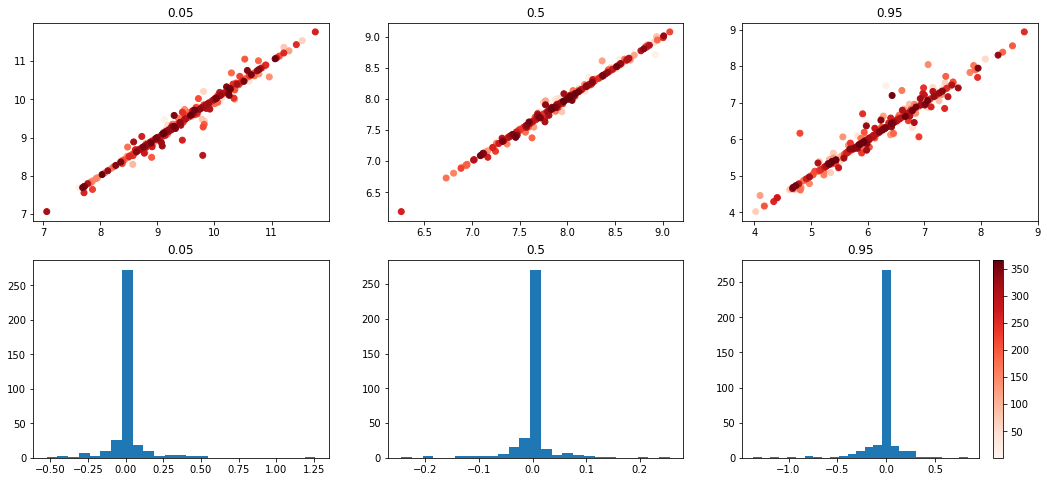

In [30]:
# TODO: replace with a call to `compare_quantile_trends_scatter_hist((refdg, histdg, simdg), (histdg_qdm, simdg_qdm), grouper='time.dayofyear')` and import the func from plotting.py

fig,axs=plt.subplots(2,3,figsize=(18,8))
ax=axs[0,0]
quants=[.05]
ret = ax.scatter((simdg_qdm.groupby('time.dayofyear').quantile(quants)-histdg_qdm.groupby('time.dayofyear').quantile(quants)),
          (simdg.groupby('time.dayofyear').quantile(quants)-histdg.groupby('time.dayofyear').quantile(quants)),
          c=simdg.groupby('time.dayofyear').mean().dayofyear, cmap='Reds')
# plt.colorbar(ret)
ax.set_title(quants[0])
ax=axs[0,1]
quants=[.5]
ret = ax.scatter((simdg_qdm.groupby('time.dayofyear').quantile(quants)-histdg_qdm.groupby('time.dayofyear').quantile(quants)),
          (simdg.groupby('time.dayofyear').quantile(quants)-histdg.groupby('time.dayofyear').quantile(quants)),
          c=simdg.groupby('time.dayofyear').mean().dayofyear, cmap='Reds')
# plt.colorbar(ret)
ax.set_title(quants[0])
ax=axs[0,2]
quants=[.95]
ret = ax.scatter((simdg_qdm.groupby('time.dayofyear').quantile(quants)-histdg_qdm.groupby('time.dayofyear').quantile(quants)),
          (simdg.groupby('time.dayofyear').quantile(quants)-histdg.groupby('time.dayofyear').quantile(quants)),
          c=simdg.groupby('time.dayofyear').mean().dayofyear, cmap='Reds')
plt.colorbar(ret)
ax.set_title(quants[0])

ax=axs[1,0]
quants=[.05]
ret = ax.hist(((simdg_qdm.groupby('time.dayofyear').quantile(quants)-histdg_qdm.groupby('time.dayofyear').quantile(quants))
               - (simdg.groupby('time.dayofyear').quantile(quants)-histdg.groupby('time.dayofyear').quantile(quants))).squeeze(),
             bins=25)
# plt.colorbar(ret)
ax.set_title(quants[0])
ax=axs[1,1]
quants=[.5]
ret = ax.hist(((simdg_qdm.groupby('time.dayofyear').quantile(quants)-histdg_qdm.groupby('time.dayofyear').quantile(quants))
          - (simdg.groupby('time.dayofyear').quantile(quants)-histdg.groupby('time.dayofyear').quantile(quants))).squeeze(),
          bins=25)
# plt.colorbar(ret)
ax.set_title(quants[0])
ax=axs[1,2]
quants=[.95]
ret = ax.hist(((simdg_qdm.groupby('time.dayofyear').quantile(quants)-histdg_qdm.groupby('time.dayofyear').quantile(quants))
          -(simdg.groupby('time.dayofyear').quantile(quants)-histdg.groupby('time.dayofyear').quantile(quants))).squeeze(),
          bins=25)
ax.set_title(quants[0])


## Select non-leap years only

In [31]:
import calendar

refdg['is_leap'] = refdg.time.dt.year.to_pandas().apply(calendar.isleap)
histdg['is_leap'] = histdg.time.dt.year.to_pandas().apply(calendar.isleap)
simdg['is_leap'] = simdg.time.dt.year.to_pandas().apply(calendar.isleap)

In [32]:
refdgnoleap = refdg.where(refdg.is_leap==False,drop=True)
histdgnoleap = histdg.where(histdg.is_leap==False, drop=True)
simdgnoleap = simdg.where(simdg.is_leap==False, drop=True)

In [33]:
QMdgnoleap = sdba.adjustment.EmpiricalQuantileMapping(kind=kind, group="time.dayofyear", nquantiles=nquantiles)
QMdgnoleap.train(refdgnoleap, histdgnoleap)
simdgnoleap_eqm = QMdgnoleap.adjust(simdgnoleap)
    
DQMdgnoleap = sdba.adjustment.DetrendedQuantileMapping(kind=kind, group="time.dayofyear", nquantiles=nquantiles)
DQMdgnoleap.train(refdgnoleap, histdgnoleap)
simdgnoleap_dqm = DQMdgnoleap.adjust(simdgnoleap, detrend=0)

QDMdgnoleap = sdba.adjustment.QuantileDeltaMapping(kind=kind, group="time.dayofyear", nquantiles=nquantiles)
QDMdgnoleap.train(refdgnoleap, histdgnoleap)
simdgnoleap_qdm = QDMdgnoleap.adjust(simdgnoleap)
histdgnoleap_qdm = QDMdgnoleap.adjust(histdgnoleap)

extrapolate_qm @@@@@@@
extrapolate_qm @@@@@@@
extrapolate_qm @@@@@@@
extrapolate_qm @@@@@@@


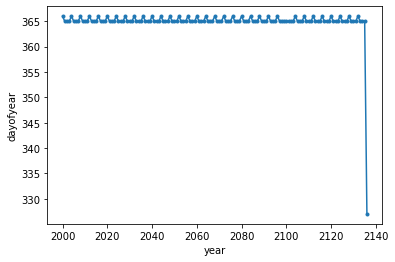

In [34]:
# confirming that day of year is shifted in non-leap years vs leap years
simdg.time.dt.dayofyear.groupby('time.year').max().plot(marker='.') # max day number in each year by year

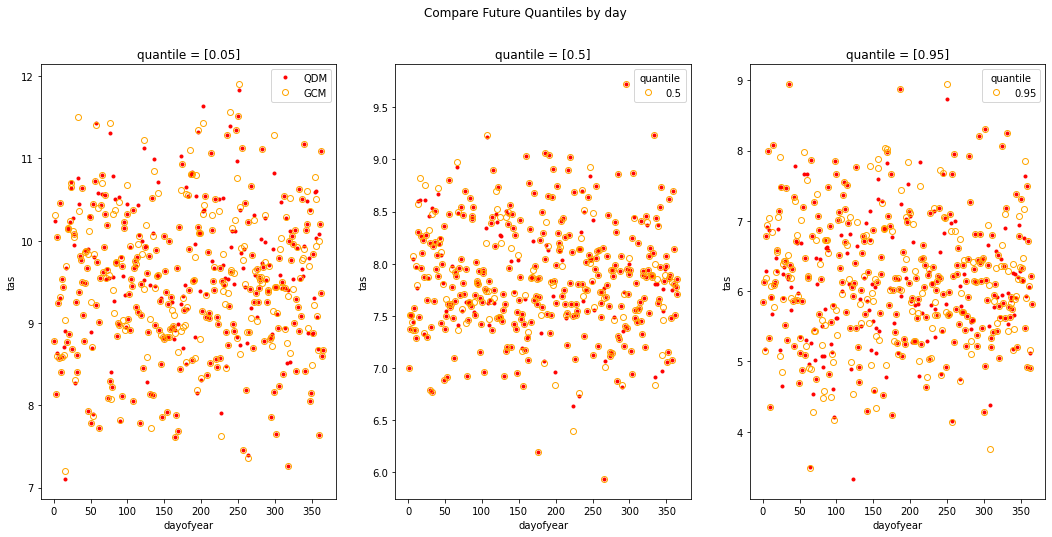

In [35]:
# TODO update with plotting function call instead

fig,axs=plt.subplots(1,3,figsize=(18,8))
quants=[.05,]
ax=axs[0]
_ = (simdgnoleap_qdm.groupby('time.dayofyear').quantile(quants)
     -histdgnoleap_qdm.groupby('time.dayofyear').quantile(quants)).plot.line(ax=ax, x='dayofyear', color='red', linestyle='none', marker='.', label="QDM")
_ = (simdgnoleap.groupby('time.dayofyear').quantile(quants)
     -histdgnoleap.groupby('time.dayofyear').quantile(quants)).plot.line(ax=ax, x='dayofyear', color='orange', linestyle='none', marker='o', mfc='none', label="GCM")
ax.legend()

quants=[.5,]
ax=axs[1]
_ = (simdgnoleap_qdm.groupby('time.dayofyear').quantile(quants)
     -histdgnoleap_qdm.groupby('time.dayofyear').quantile(quants)).plot.line(ax=ax, x='dayofyear', color='red', linestyle='none', marker='.', label="QDM")
_ = (simdgnoleap.groupby('time.dayofyear').quantile(quants)
     -histdgnoleap.groupby('time.dayofyear').quantile(quants)).plot.line(ax=ax, x='dayofyear', color='orange', linestyle='none', marker='o', mfc='none', label="GCM")


quants=[.95]
ax=axs[2]
_ = (simdgnoleap_qdm.groupby('time.dayofyear').quantile(quants)
     -histdgnoleap_qdm.groupby('time.dayofyear').quantile(quants)).plot.line(ax=ax, x='dayofyear', color='red', linestyle='none', marker='.', label="QDM")
_ = (simdgnoleap.groupby('time.dayofyear').quantile(quants)
     -histdgnoleap.groupby('time.dayofyear').quantile(quants)).plot.line(ax=ax, x='dayofyear', color='orange', linestyle='none', marker='o', mfc='none', label="GCM")

_ = fig.suptitle('Compare Future Quantiles by day ')

Text(0.5, 1.0, '0.95')

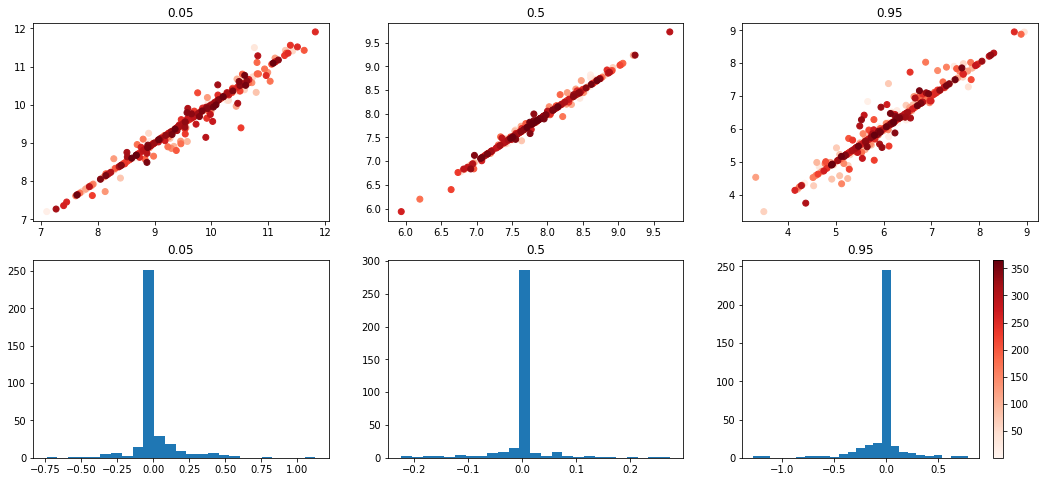

In [36]:
# TODO update with plotting function call instead

fig,axs=plt.subplots(2,3,figsize=(18,8))
ax=axs[0,0]
quants=[.05]
ret = ax.scatter((simdgnoleap_qdm.groupby('time.dayofyear').quantile(quants)-histdgnoleap_qdm.groupby('time.dayofyear').quantile(quants)),
          (simdgnoleap.groupby('time.dayofyear').quantile(quants)-histdgnoleap.groupby('time.dayofyear').quantile(quants)),
          c=simdgnoleap.groupby('time.dayofyear').mean().dayofyear, cmap='Reds')
# plt.colorbar(ret)
ax.set_title(quants[0])
ax=axs[0,1]
quants=[.5]
ret = ax.scatter((simdgnoleap_qdm.groupby('time.dayofyear').quantile(quants)-histdgnoleap_qdm.groupby('time.dayofyear').quantile(quants)),
          (simdgnoleap.groupby('time.dayofyear').quantile(quants)-histdgnoleap.groupby('time.dayofyear').quantile(quants)),
          c=simdgnoleap.groupby('time.dayofyear').mean().dayofyear, cmap='Reds')
# plt.colorbar(ret)
ax.set_title(quants[0])
ax=axs[0,2]
quants=[.95]
ret = ax.scatter((simdgnoleap_qdm.groupby('time.dayofyear').quantile(quants)-histdgnoleap_qdm.groupby('time.dayofyear').quantile(quants)),
          (simdgnoleap.groupby('time.dayofyear').quantile(quants)-histdgnoleap.groupby('time.dayofyear').quantile(quants)),
          c=simdgnoleap.groupby('time.dayofyear').mean().dayofyear, cmap='Reds')
plt.colorbar(ret)
ax.set_title(quants[0])

ax=axs[1,0]
quants=[.05]
ret = ax.hist(((simdgnoleap_qdm.groupby('time.dayofyear').quantile(quants)-histdgnoleap_qdm.groupby('time.dayofyear').quantile(quants))
               - (simdgnoleap.groupby('time.dayofyear').quantile(quants)-histdgnoleap.groupby('time.dayofyear').quantile(quants))).squeeze(),
             bins=25)
# plt.colorbar(ret)
ax.set_title(quants[0])
ax=axs[1,1]
quants=[.5]
ret = ax.hist(((simdgnoleap_qdm.groupby('time.dayofyear').quantile(quants)-histdgnoleap_qdm.groupby('time.dayofyear').quantile(quants))
          - (simdgnoleap.groupby('time.dayofyear').quantile(quants)-histdgnoleap.groupby('time.dayofyear').quantile(quants))).squeeze(),
          bins=25)
# plt.colorbar(ret)
ax.set_title(quants[0])
ax=axs[1,2]
quants=[.95]
ret = ax.hist(((simdgnoleap_qdm.groupby('time.dayofyear').quantile(quants)-histdgnoleap_qdm.groupby('time.dayofyear').quantile(quants))
          -(simdgnoleap.groupby('time.dayofyear').quantile(quants)-histdgnoleap.groupby('time.dayofyear').quantile(quants))).squeeze(),
          bins=25)
ax.set_title(quants[0])


Seems like removing leap days only made the quantile changes match up a little bit better

## Test month grouping
using the daily time series from above to bias correct on a monthly basis

In [37]:
random = True
nquantiles = 120
print('nquantiles', nquantiles)



QMm = sdba.adjustment.EmpiricalQuantileMapping(kind=kind, group="time.month", nquantiles=nquantiles)
QMm.train(refdg, histdg)
simm_eqm = QMm.adjust(simdg)
    
DQMm = sdba.adjustment.DetrendedQuantileMapping(kind=kind, group="time.month", nquantiles=nquantiles)
DQMm.train(refdg, histdg)
simm_dqm = DQMm.adjust(simdg, detrend=0)

QDMm = sdba.adjustment.QuantileDeltaMapping(kind=kind, group="time.month", nquantiles=nquantiles)
QDMm.train(refdg, histdg)
simm_qdm = QDMm.adjust(simdg)
histm_qdm = QDMm.adjust(histdg)

nquantiles 120
extrapolate_qm @@@@@@@
extrapolate_qm @@@@@@@
extrapolate_qm @@@@@@@
extrapolate_qm @@@@@@@


In [44]:
# if the grouping is monthly, presumably the method grabs all days in the month, over all the times, and builds the adjustment factors. Let's see

QDMm.ds

<xarray.Dataset>
Dimensions:    (month: 12, quantiles: 122)
Coordinates:
  * quantiles  (quantiles) float64 1e-06 0.004167 0.0125 ... 0.9875 0.9958 1.0
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    af         (month, quantiles) float64 -16.85 -14.74 -13.15 ... 5.125 10.04
    hist_q     (month, quantiles) float64 -13.55 -11.08 -9.817 ... 8.803 12.66
Attributes:
    adj_params:  QuantileDeltaMapping(nquantiles=120, kind='+', group=Grouper...

Text(0.5, 1.0, 'Monthly mean, monthly grouping')

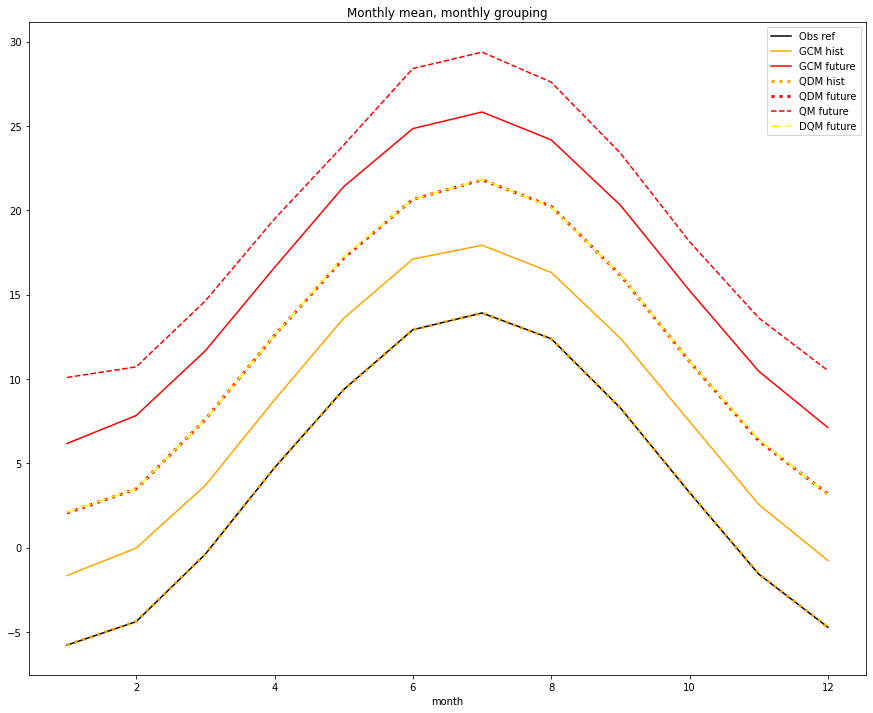

In [38]:
fig, ax = plt.subplots(1,1,figsize=(15,12))
refdg.groupby('time.month').mean().plot(color='k', label='Obs ref')
histdg.groupby('time.month').mean().plot(color='orange', label='GCM hist')
simdg.groupby('time.month').mean().plot(color='r', label='GCM future')
histm_qdm.groupby('time.month').mean().plot(color='orange', linestyle=':', linewidth=3, label='QDM hist')
simm_qdm.groupby('time.month').mean().plot(color='r', linestyle=':', linewidth=3, label='QDM future')
simm_eqm.groupby('time.month').mean().plot(color='r', linestyle='--', label='QM future')
simm_dqm.groupby('time.month').mean().plot(color='yellow', linestyle='-.', label='DQM future')
ax.legend()
ax.set_title('Monthly mean, monthly grouping')

Text(0.5, 1.0, 'Monthly quantiles, monthly grouping')

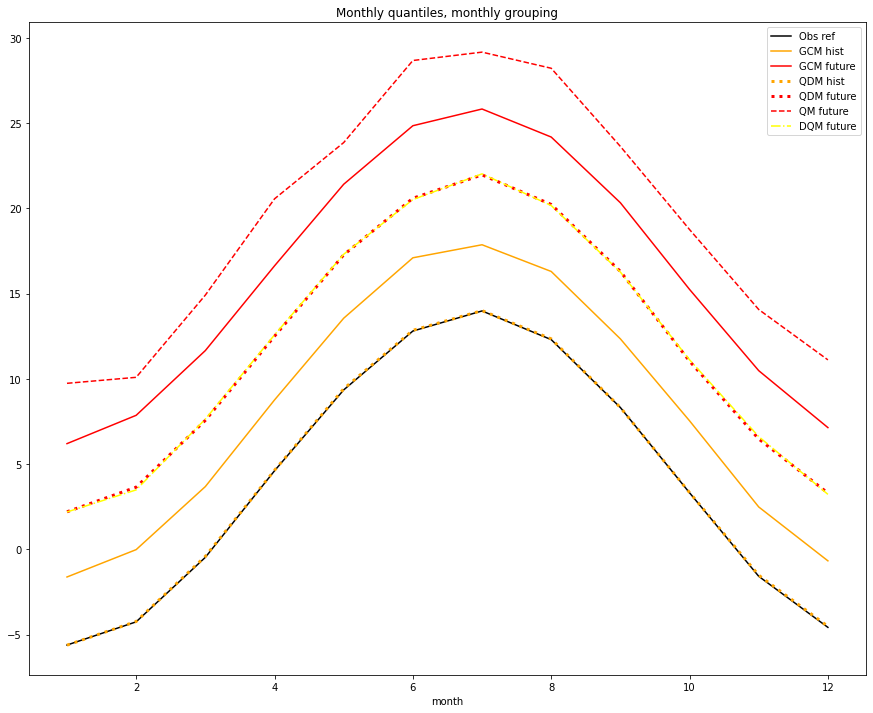

In [39]:

quants=[.5,]
fig, ax = plt.subplots(1,1,figsize=(15,12))
refdg.groupby('time.month').quantile(quants).plot(color='k', label='Obs ref')
histdg.groupby('time.month').quantile(quants).plot(color='orange', label='GCM hist')
simdg.groupby('time.month').quantile(quants).plot(color='r', label='GCM future')
histm_qdm.groupby('time.month').quantile(quants).plot(color='orange', linestyle=':', linewidth=3, label='QDM hist')
simm_qdm.groupby('time.month').quantile(quants).plot(color='r', linestyle=':', linewidth=3, label='QDM future')
simm_eqm.groupby('time.month').quantile(quants).plot(color='r', linestyle='--', label='QM future')
simm_dqm.groupby('time.month').quantile(quants).plot(color='yellow', linestyle='-.', label='DQM future')
ax.legend()
ax.set_title('Monthly quantiles, monthly grouping')

In [42]:
simdg_qdm

<xarray.DataArray (time: 50000)>
array([ 5.30398102,  6.5051031 ,  4.94165402, ..., -0.23602307,
        5.63785914, 10.62935113])
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2136-11-22
Attributes:
    xclim_history:  [2021-03-02 06:43:04] : Bias-adjusted with QuantileDeltaM...

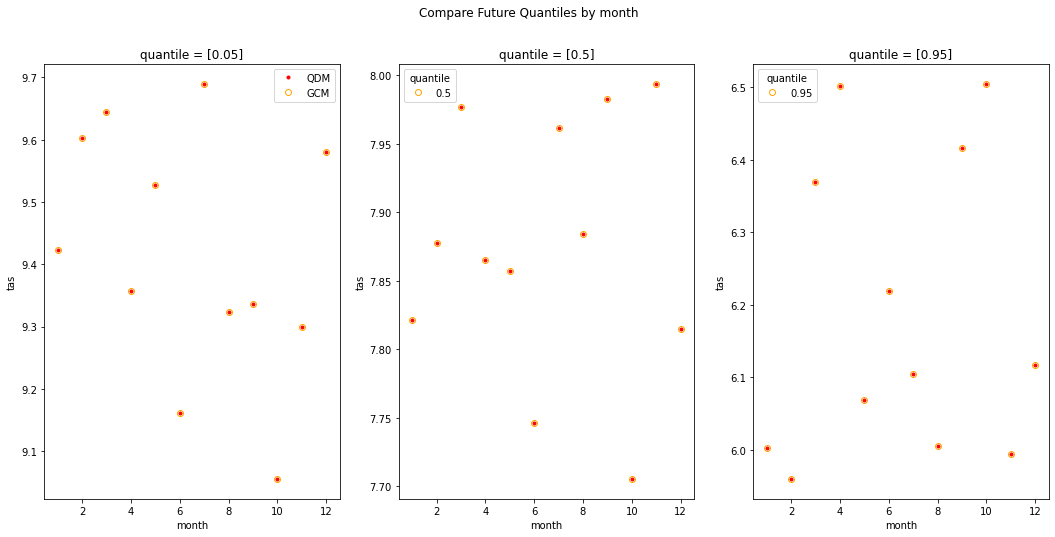

In [47]:
groupby = 'time.month'

# TODO: update with plotting function call instead

fig,axs=plt.subplots(1,3,figsize=(18,8))
quants=[.05,]
ax=axs[0]
_ = (simm_qdm.groupby(groupby).quantile(quants)
     -histm_qdm.groupby(groupby).quantile(quants)).plot.line(ax=ax, x='month', color='red', linestyle='none', marker='.', label="QDM")
_ = (simdg.groupby(groupby).quantile(quants)
     -histdg.groupby(groupby).quantile(quants)).plot.line(ax=ax, x='month', color='orange', linestyle='none', marker='o', mfc='none', label="GCM")
ax.legend()

quants=[.5,]
ax=axs[1]
_ = (simm_qdm.groupby(groupby).quantile(quants)
     -histm_qdm.groupby(groupby).quantile(quants)).plot.line(ax=ax, x='month', color='red', linestyle='none', marker='.', label="QDM")
_ = (simdg.groupby(groupby).quantile(quants)
     -histdg.groupby(groupby).quantile(quants)).plot.line(ax=ax, x='month', color='orange', linestyle='none', marker='o', mfc='none', label="GCM")


quants=[.95]
ax=axs[2]
_ = (simm_qdm.groupby(groupby).quantile(quants)
     -histm_qdm.groupby(groupby).quantile(quants)).plot.line(ax=ax, x='month', color='red', linestyle='none', marker='.', label="QDM")
_ = (simdg.groupby(groupby).quantile(quants)
     -histdg.groupby(groupby).quantile(quants)).plot.line(ax=ax, x='month', color='orange', linestyle='none', marker='o', mfc='none', label="GCM")

_ = fig.suptitle('Compare Future Quantiles by month ')

BOOM